Clustering Schoolwork

@author：刘士坤 2016011371

以谱聚类或者马尔科夫聚类对鸢尾花数据集进行处理，得到类似如下图所示（Normalized Cut），并输出正确率。

#### 导入相应的库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#### 获取鸢尾花数据集

In [2]:
data = load_iris()
target = data.target
data = data.data

## 确定一个合适的阈值，只有两个样本之间的相似度大于该阈值时，这两个样本之间才有一条边

In [3]:
# 计算每个样本的K近邻
def N_k(A,K):
    N = []
    for i in range(len(A)):
        j = np.argsort(A[i])
        j = j[-k:-1]
        N.append(j)
    return np.array(N)

## 求取带权邻接矩阵

In [4]:
#计算带权邻接矩阵 A
def adj_mat(data):
    N = data.shape[0]
    A = np.zeros((N,N))
    
    for i in range(N):
        for j in range(i+1):
            A[i,j] = np.dot(data[i]-data[j],data[i]-data[j])
            if(i!=j):
                A[j,i] = A[i,j] 
                
    A_mat = np.exp(-0.5*A)
    return  A_mat

## 将鸢尾花数据集画成图的形式

根据可视化结果，来调整阈值 ，选取最相似的前K个节点来确定阈值，降低阈值选择的难度

##### 使用PCA降维使得4维数据变成2维，目的是数据2D可视化

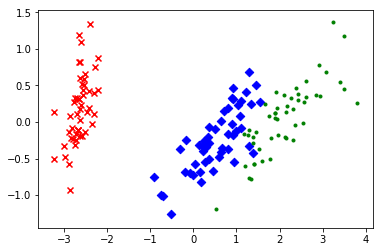

In [5]:
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(data)

red_x, red_y = [], []
blue_x, blue_y = [], []
green_x, green_y = [], []
lable=target
for i in range(len(reduced_X)):
    if lable[i] == 0:
        red_x.append(reduced_X[i][0])
        red_y.append(reduced_X[i][1])
    elif lable[i] == 1:
        blue_x.append(reduced_X[i][0])
        blue_y.append(reduced_X[i][1])
    else:
        green_x.append(reduced_X[i][0])
        green_y.append(reduced_X[i][1])

plt.scatter(red_x, red_y, c='r', marker='x')
plt.scatter(blue_x, blue_y, c='b', marker='D')
plt.scatter(green_x, green_y, c='g', marker='.')
plt.show()

##### 通过手动调节，调整 K值，确定无向图

In [6]:
k=12
n_k = N_k(adj_mat(data),k)

##### 在聚类之前画的无向图

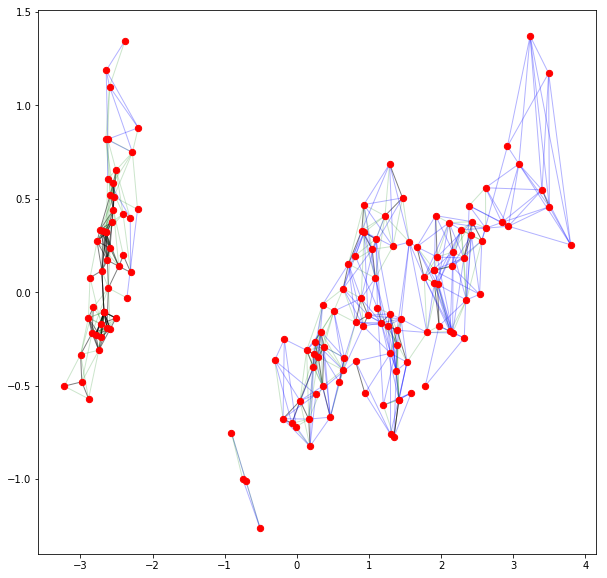

In [7]:
#绘制网络 nx.draw()
plt.figure(figsize=(10,10))
G = nx.Graph()
#根据带权邻接矩阵画图，由近邻K（n_k）决定是否相连
A_mat=adj_mat(data)
for i in range(len(A_mat)):
    for j in range(len(A_mat)):
        if(i in n_k[j] and j in n_k[i]):
            G.add_edge(i,j,weight=A_mat[i,j])

# 由生成的节点将网络图上的边按权重分成3组
edge1=[]
edge2=[]
edge3=[]
for (m,n,l) in G.edges(data='weight'):
    if l >= 0.96:
        edge1.append((m,n))
    elif l < 0.92:
        edge2.append((m,n))
    else:
        edge3.append((m,n))
        
#根据pca降维确定的点位置
pos= reduced_X
# 画节点  
nx.draw_networkx_nodes(G, pos,node_color='r',node_shape='o',node_size=40)
# 画边
nx.draw_networkx_edges(G, pos, edgelist=edge1,alpha=0.5,edge_color='k',style='solid')
nx.draw_networkx_edges(G, pos, edgelist=edge2,alpha=0.3,edge_color='b',style='solid')
nx.draw_networkx_edges(G, pos, edgelist=edge3,alpha=0.2,edge_color='g',style='solid')

plt.savefig("鸢尾花数据集画成图.png")# 保存图片用于之后的作业提交
plt.show()

## 根据邻接矩阵进行聚类

##### 谱聚类 算法的实现

In [8]:
#拉普拉斯矩阵
def Laplace_matrix(X,k):
    #相似度矩阵作为邻接矩阵A
    A = adj_mat(X)             #开始实现的带权邻接矩阵
    #由A得到度数矩阵和拉普拉斯矩阵
    D = np.diag(A.sum(axis=0)) #度矩阵D
    L = D - A                  # 拉普拉斯矩阵
    D = np.linalg.inv(np.sqrt(D))
    L = D.dot(L).dot(D)
    return L

#取前K个单位化的特征向量,找到最小的k个特征值对应的特征向量组成矩阵U
def spectral_clustering(X,k):
    L=Laplace_matrix(X,k)
    m, n = np.linalg.eig(L)
    i = np.argsort(m)[:k]
    U = n[:, i]
    V=normalization(U)
    return V

#归一化处理
def normalization(U):
    #对U的每一行进行归一化，得到矩阵Y
    normalizer = np.linalg.norm(U, axis=1)
    normalizer = np.repeat(np.transpose([normalizer]), k, axis=1)
    Y = U / normalizer
    return Y

##### 用KMeans生成新的簇

In [9]:
clf = KMeans(n_clusters=3)
y = clf.fit_predict(spectral_clustering(data,k))

## 将聚类结果可视化，重新转换成图的形式

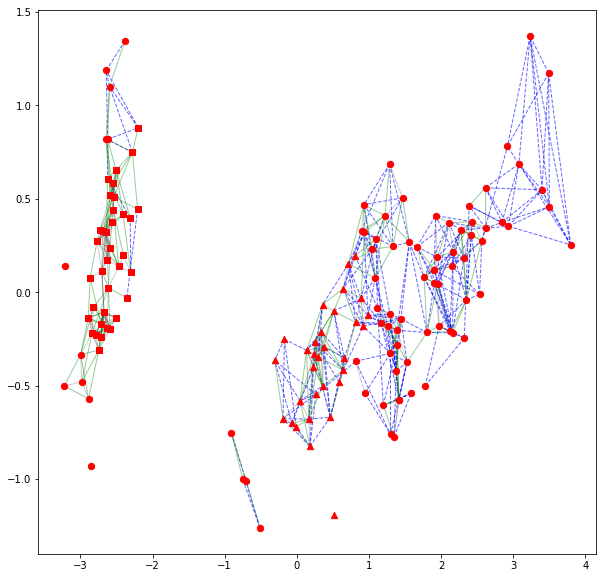

In [10]:
#绘制网络 nx.draw()
plt.figure(figsize=(10,10))
G = nx.Graph()

# 根据带权邻接矩阵画图
A = adj_mat(data)
for i in range(len(A)):
    for j in range(len(A)):
        if(i in n_k[j] and j in n_k[i]):
            G.add_edge(i,j, weight=A[i,j])
            
#由标签将节点分成3组
node1=[i for i in range(150) if y[i] == 2]
node2=[i for i in range(150) if y[i] == 1]
node3=[i for i in range(150) if y[i] == 0]

# 由生成的节点将网络图上的边按权重分成3组
edge1=[]
edge2=[]
edge3=[]
for (m,n,l) in G.edges(data='weight'):
    if l >= 0.96:
        edge1.append((m,n))
    elif l < 0.92:
        edge2.append((m,n))
    else:
        edge3.append((m,n))
        
# 画出节点
nx.draw_networkx_nodes(G, pos, node_size=40, nodelist=node1, node_shape='o')
nx.draw_networkx_nodes(G, pos, node_size=40, nodelist=node2, node_shape='^')
nx.draw_networkx_nodes(G, pos, node_size=40, nodelist=node3, node_shape='s')
# 画出边
nx.draw_networkx_edges(G, pos, edgelist=edge1, width=1, alpha=0.2, edge_color='k', style='solid')
nx.draw_networkx_edges(G, pos, edgelist=edge2, width=1, alpha=0.6, edge_color='b', style='dashed')
nx.draw_networkx_edges(G, pos, edgelist=edge3, width=1, alpha=0.4, edge_color='g', style='solid')

plt.savefig("聚类之后的图.png")# 保存图片用于之后的作业提交
plt.show()

## 求得分簇正确率

In [11]:
#计算正确率
correct = 0
for i in range(150):
    if target[i] == y[i]:
        correct=correct+1

In [12]:
#输出正确率
print("Acc:","{}%".format(correct/150*100))

Acc: 78.66666666666666%
